## CPU Price Scraper

During the CoVid-19 pandemic, the surge in prices of semiconductors garnered worldwide attention as supply chains choked up. With the establishment of price tracking sites such as https://camelcamelcamel.com/, tracking price changes of specific items have become more convenient. So we can track the recent price changes of semiconductors using basic web scraping.

In this example, we will use the browser extension Honey's price tracking feature to gather data on the historical price changes of CPUs. By searching the name of the CPU in Honey's search bar and extracting the string after "productID" in the resulting webpage, we can find the product IDs of the products we are looking for.

In [1]:
product_ids = [
'177_3f0f7ca57791d86d3c58bc8eb4a6930d_1b3329af53506c771818ecf6ebbfc0e7',
'1_b4d1018ffdf9ead5e1fb20922567437a_769db6aeff5b16d9784728b6ba957825',
'1_9317a72f850ac9973d2f0dedecdb43d5_127068e4c71522cd975cbce2f52c1585',
'1_e24808830a1bd0d58ce9d7d27113bade_05ee047bfb3ae98eab8a4cff7d2437c0',
'1_2d4c6db895b3918b35d6cbf0bc76775d_fa791e6ba40af04cd68e29e115059c1a',
'1_f2caff692f6b5a73a7951772acf0bbbe_e352dc3750c3775eba179e08ede8c145',
'1_67bfeb4569900730d1b2d24f7f1cc99a_67bfeb4569900730d1b2d24f7f1cc99a']

After choosing 7 CPUs to collect prices from, we dig a little deeper into the webpage for one of the CPUs. By inspecting the webpage (specifically looking at the "network" tab and determining which item is responsible for loading the price history), we can pinpoint the URL we need to request to get that CPU's price history.

We create a function to pull the prices for one CPU and call it in another function which creates a dataframe of all of the CPU's price histories.

In [21]:
import requests as r
import pandas as pd
import numpy as np

def grab_px_hist(prod_id):
    action_url = 'https://d.joinhoney.com/v3?operationName=web_getProductPriceHistory&variables={"productId":"'\
                 + prod_id +'","timeframe":120}'
    
    res = r.get(action_url)
    px_df = pd.DataFrame(res.json()['data']['getProductPriceHistory']['history'])
    return px_df


def constr_px_table(prod_ids):
    px_table = None
    
    for ind,prod_id in enumerate(prod_ids):
        if px_table is None:
            prod_px_df = grab_px_hist(prod_id)
            px_table = prod_px_df[['day','lo']]
            px_table.rename(columns={"lo": "prod_" + str(ind) + "_px"},inplace=True)
        else:
            prod_px_df = grab_px_hist(prod_id)
            add_df = prod_px_df[['day','lo']]
            add_df.rename(columns={"lo": "prod_" + str(ind) + "_px"},inplace=True)
            px_table = px_table.merge(add_df, on = 'day')
    
    return px_table

res = constr_px_table(product_ids)
res

,day,prod_0_px,prod_1_px,prod_2_px,prod_3_px,prod_4_px,prod_5_px,prod_6_px
0,2022-06-24,29949,29995,38215,19395,28996,20298,14499
1,2022-06-25,29949,29995,37616,19395,28996,20298,14499
2,2022-06-26,29949,29995,37616,19395,28996,20298,14690
3,2022-06-27,29949,29995,37616,19395,28996,20298,14499
4,2022-06-28,29949,29995,37616,19395,28996,20999,12999
...,...,...,...,...,...,...,...,...
83,2022-09-19,29949,31346,32799,19275,24987,20899,15900
84,2022-09-20,29949,30184,31000,19395,24987,20899,11999
85,2022-09-21,29949,32400,31000,19395,22499,20899,15900
86,2022-09-22,29949,31348,30800,19395,25799,20899,15900


Note that the prices are in cents and for each observed date a high and low price is recorded. We will be collecting the low prices.

However, it is difficult to compare the relative price changes across products. We will resolve this by using percent change across all CPUs and visualizing the result.

C:\Users\13127\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


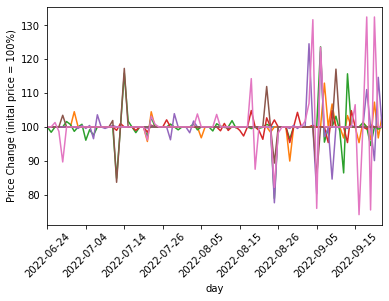

In [43]:
import matplotlib.pyplot as plt

def add_pct_chg(px_table):
    pct_chg_df = pd.DataFrame({'day':list(px_table['day'].values)})
    for prod_px in px_table.columns:
        if prod_px != 'day':
            chg_series = [100] + [100 + chg*100 for chg in list(px_table[prod_px].pct_change())[1:]]
            pct_chg_df[prod_px + "_pct_chg"] = chg_series
    pct_chg_df.set_index('day',inplace=True)
    
    ax = pct_chg_df.plot()
    plt.xticks(rotation=45)
    plt.ylabel('Price Change (inital price = 100%)')
    ax.get_legend().remove()
    return pct_chg_df

res_pct = add_pct_chg(res)

We can immediately observe that certain periods exhibit higher volatility than other periods, suggesting heteroskedasticity. In addition, the maximum lookback is only 120 days, and even then, not all dates are being displayed because we were performing an inner join when we were creating the aggregate CPU price table, meaning only days in which all CPUs had a valid observation are being considered.

A natural extension of the above analysis could be to set up an automated scraper that updates that day's price observation and store the data externally so that we can have access to price histories longer than 120 days. In addition, instead of aggregating all of the prices, we could collect data for one model at a time, providing a less sparse data series to work with - although when comparisons across CPUs need to be made, some way of backfilling missing observations for certain dates must be designed.